# Liesel-GAM Demo Notebook

In [1]:
%load_ext autoreload
%autoreload 2

## Setup and Imports

In [2]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [3]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


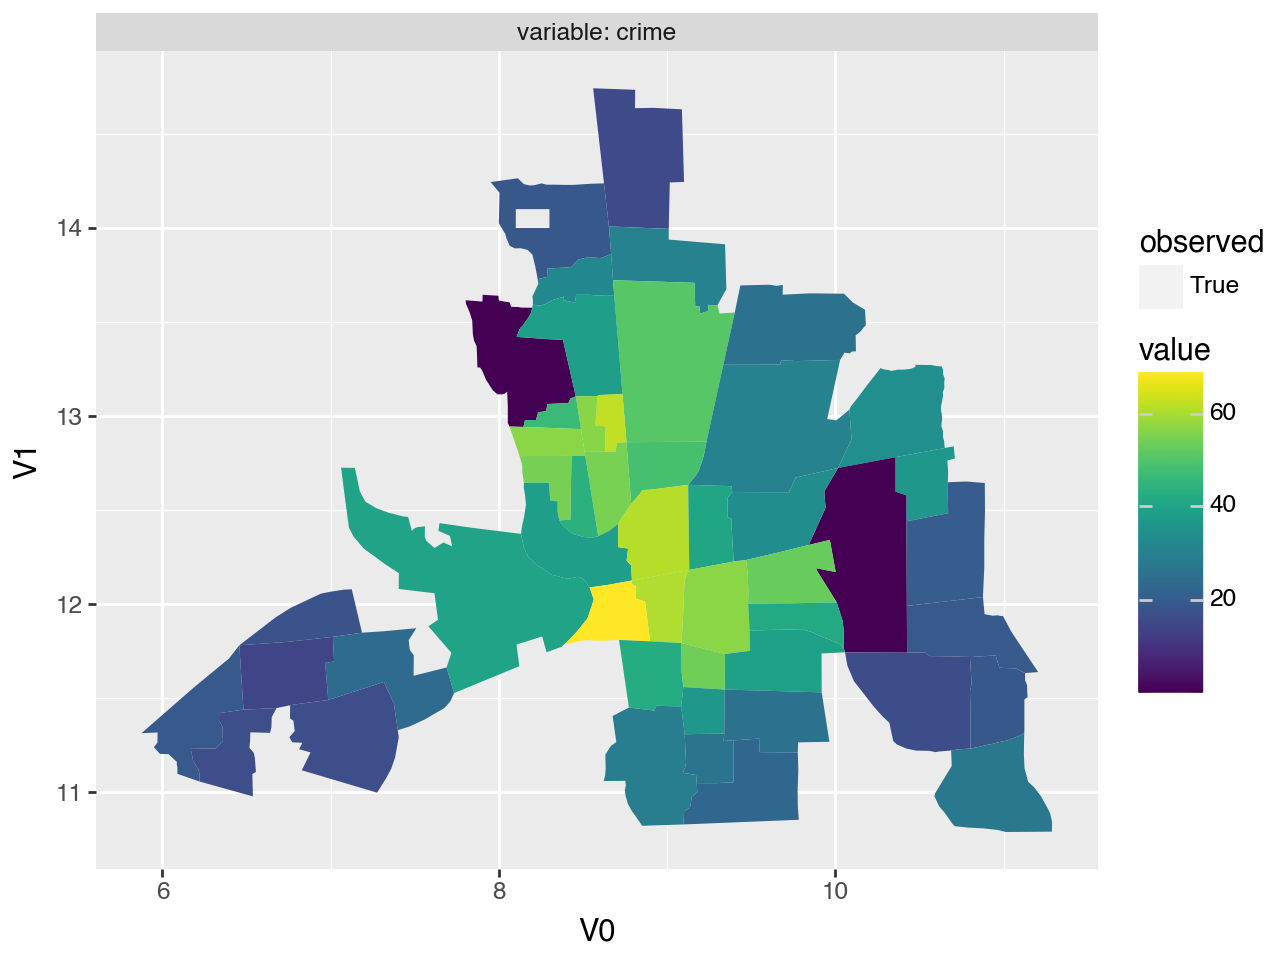

In [4]:
gam.plot_polys(region="district", which=["crime"], df=columb, polys=polys)

## Model Definition

### Setup response model

In [5]:
i = np.arange(columb.shape[0])
i10 = i[:10]
i20 = i[11:20]
i30 = i[21:30]
irest = i[31:]
i = np.concatenate((i10, i20, i30, irest))
df = columb.iloc[i, :].reset_index()

In [6]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

tb = gam.TermBuilder.from_df(df)
loc += tb.mrf("district", polys=polys, factor_scale=True)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


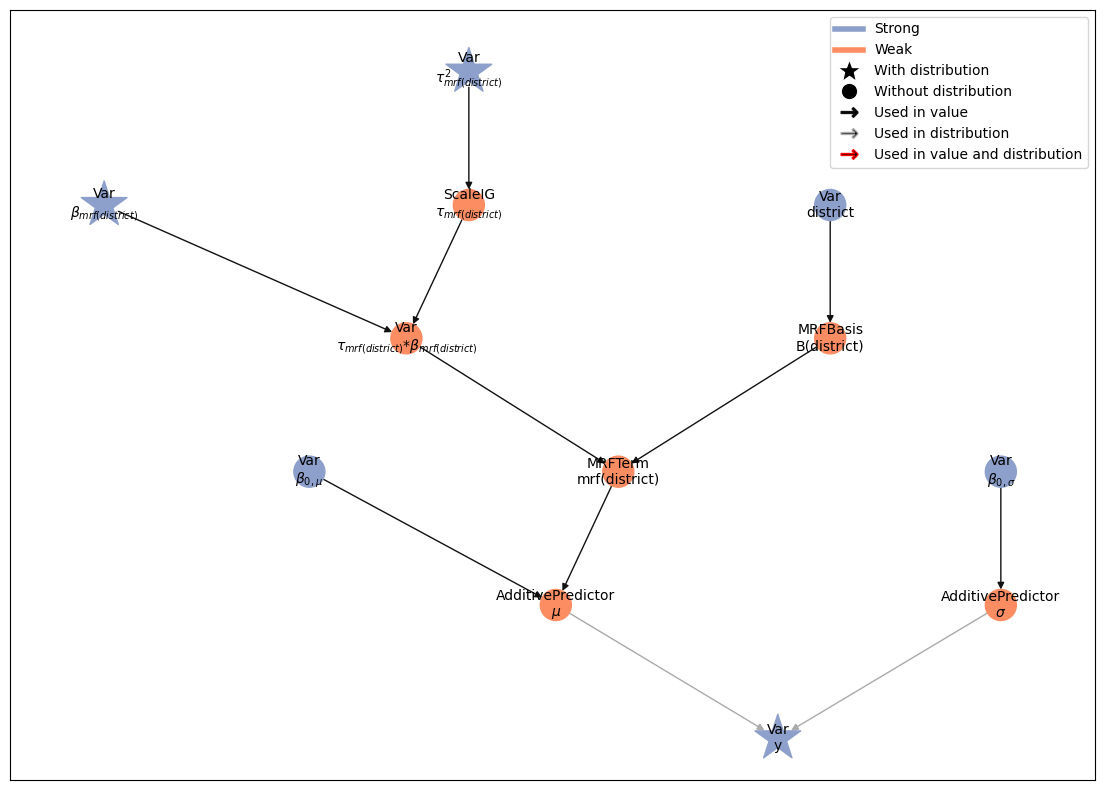

In [7]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{mrf(district)}$', '$\\tau_{mrf(district)}^2$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:02<00:00,  5.82chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1097.70chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 0, 0, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████

### MCMC summary

In [9]:
summary = gs.Summary(results)
summary

Parameter summary:

                                   kernel       mean        sd     q_0.05  \
parameter                index                                              
$\beta_{0,\mu}$          ()     kernel_01  34.780041  2.404630  30.803739   
$\beta_{0,\sigma}$       ()     kernel_00   2.760593  0.159538   2.473064   
$\beta_{mrf(district)}$  (0,)   kernel_02   0.137169  1.038965  -1.612846   
                         (1,)   kernel_02   0.000231  0.999837  -1.587474   
                         (2,)   kernel_02   0.123298  0.982313  -1.488002   
                         (3,)   kernel_02   0.152586  0.999133  -1.485408   
                         (4,)   kernel_02   0.011319  0.962408  -1.560767   
                         (5,)   kernel_02  -0.020208  0.981207  -1.658401   
                         (6,)   kernel_02   0.024669  0.984166  -1.627175   
                         (7,)   kernel_02  -0.048845  0.967098  -1.620675   
                         (8,)   kernel_02   0.020926  0.957212  -1.517299   
                         (9,)   kernel_02  -0.152667  1.029823  -1.833527   
                         (10,)  kernel_02   0.076200  0.995815  -1.578645   
                         (11,)  kernel_02  -0.090369  0.984931  -1.741849   
                         (12,)  kernel_02   0.046546  0.952450  -1.514629   
                         (13,)  kernel_02  -0.062928  0.968248  -1.633566   
                         (14,)  kernel_02  -0.018854  0.979377  -1.572799   
                         (15,)  kernel_02  -0.160397  1.008449  -1.841680   
                         (16,)  kernel_02   0.079111  0.961697  -1.512433   
                         (17,)  kernel_02   0.012230  0.971717  -1.585575   
                         (18,)  kernel_02   0.041654  0.975957  -1.603261   
                         (19,)  kernel_02   0.086211  0.988577  -1.568870   
                         (20,)  kernel_02  -0.065580  0.986284  -1.683067   
                         (21,)  kernel_02  -0.226443  1.046268  -1.989761   
                         (22,)  kernel_02  -0.042636  0.963098  -1.617194   
                         (23,)  kernel_02   0.053273  0.969572  -1.510855   
                         (24,)  kernel_02   0.090075  0.984315  -1.562978   
                         (25,)  kernel_02   0.042929  0.972834  -1.588748   
                         (26,)  kernel_02   0.041720  0.985630  -1.563166   
                         (27,)  kernel_02  -0.074781  0.992313  -1.618697   
                         (28,)  kernel_02  -0.117043  0.970377  -1.702076   
                         (29,)  kernel_02   0.069021  0.978701  -1.525159   
                         (30,)  kernel_02  -0.096437  0.964421  -1.669554   
                         (31,)  kernel_02   0.017873  0.950717  -1.536713   
                         (32,)  kernel_02   0.125358  0.974237  -1.483069   
                         (33,)  kernel_02   0.095879  0.977996  -1.534657   
                         (34,)  kernel_02  -0.072749  0.965649  -1.637240   
                         (35,)  kernel_02   0.113610  0.960202  -1.500116   
                         (36,)  kernel_02  -0.141623  0.982720  -1.749085   
                         (37,)  kernel_02   0.004182  0.968337  -1.627030   
                         (38,)  kernel_02  -0.021816  0.963975  -1.622754   
                         (39,)  kernel_02   0.157257  0.968306  -1.474132   
                         (40,)  kernel_02   0.228730  1.023271  -1.557521   
                         (41,)  kernel_02   0.182226  0.980139  -1.483704   
                         (42,)  kernel_02  -0.337858  1.018921  -1.969633   
                         (43,)  kernel_02  -0.182997  0.979373  -1.730598   
                         (44,)  kernel_02   0.441531  1.036570  -1.372376   
                         (45,)  kernel_02  -0.537643  1.058998  -2.165002   
                         (46,)  kernel_02   0.184042  0.898490  -1.346271   
                         (47,)  kernel_02   0.412037 

## Plots

In [10]:
samples = results.get_posterior_samples()

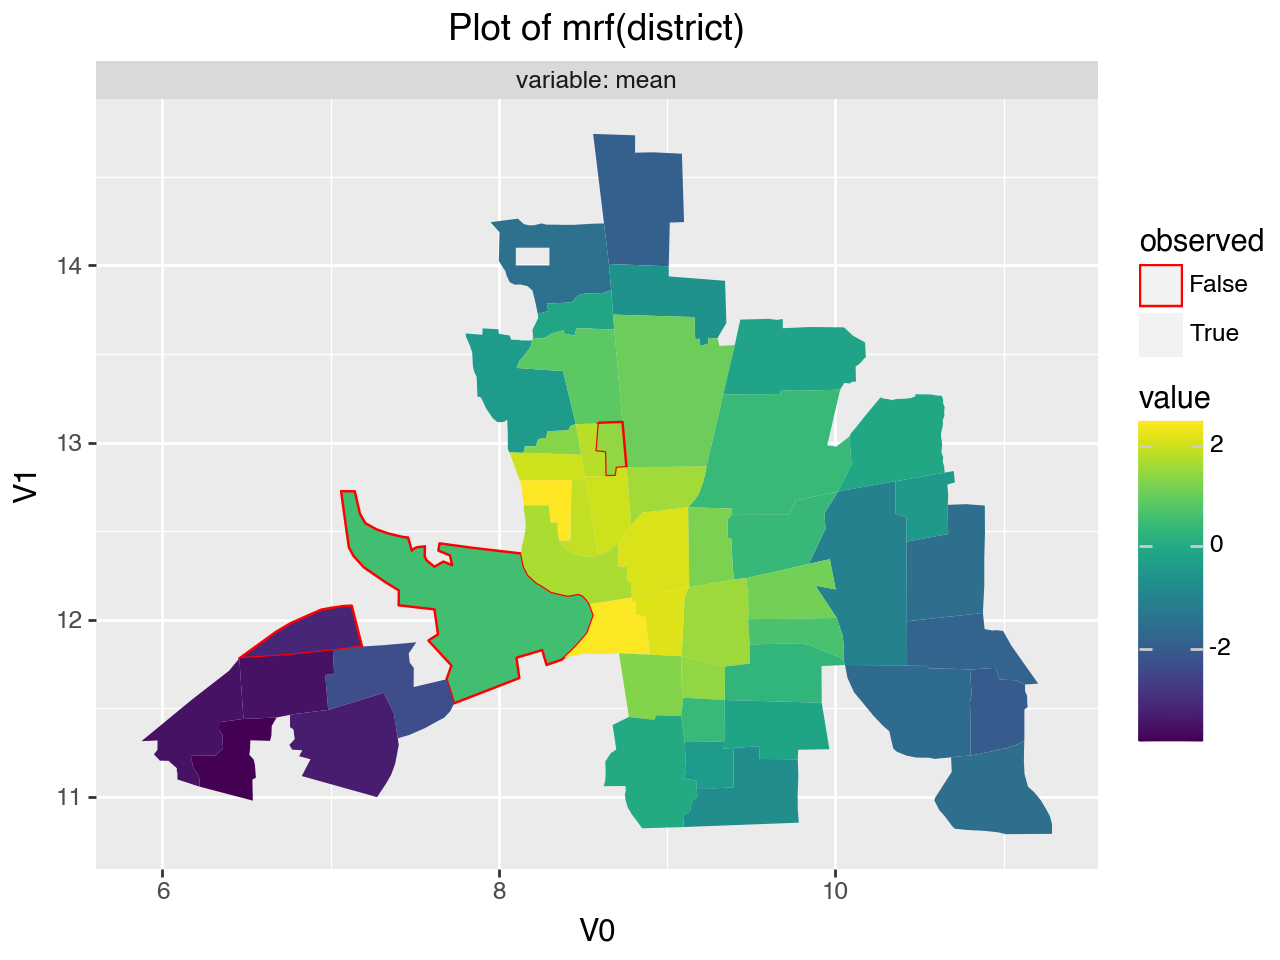

In [11]:
gam.plot_regions(term=loc.terms["mrf(district)"], samples=samples, polys=polys)

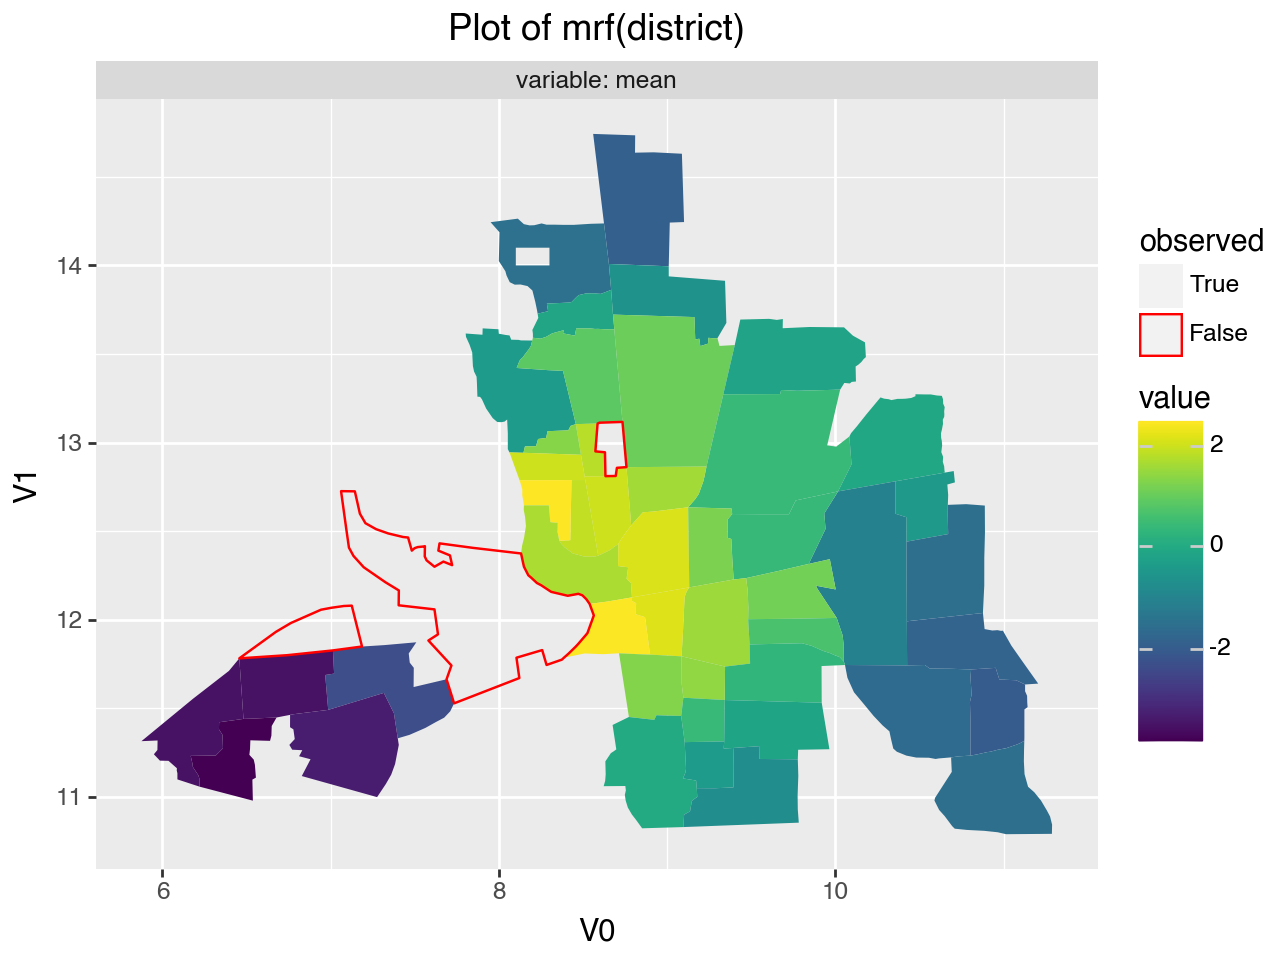

In [12]:
gam.plot_regions(
    term=loc.terms["mrf(district)"],
    samples=samples,
    polys=polys,
    show_unobserved=False,
    unobserved_color="red",
    observed_color="none",
)

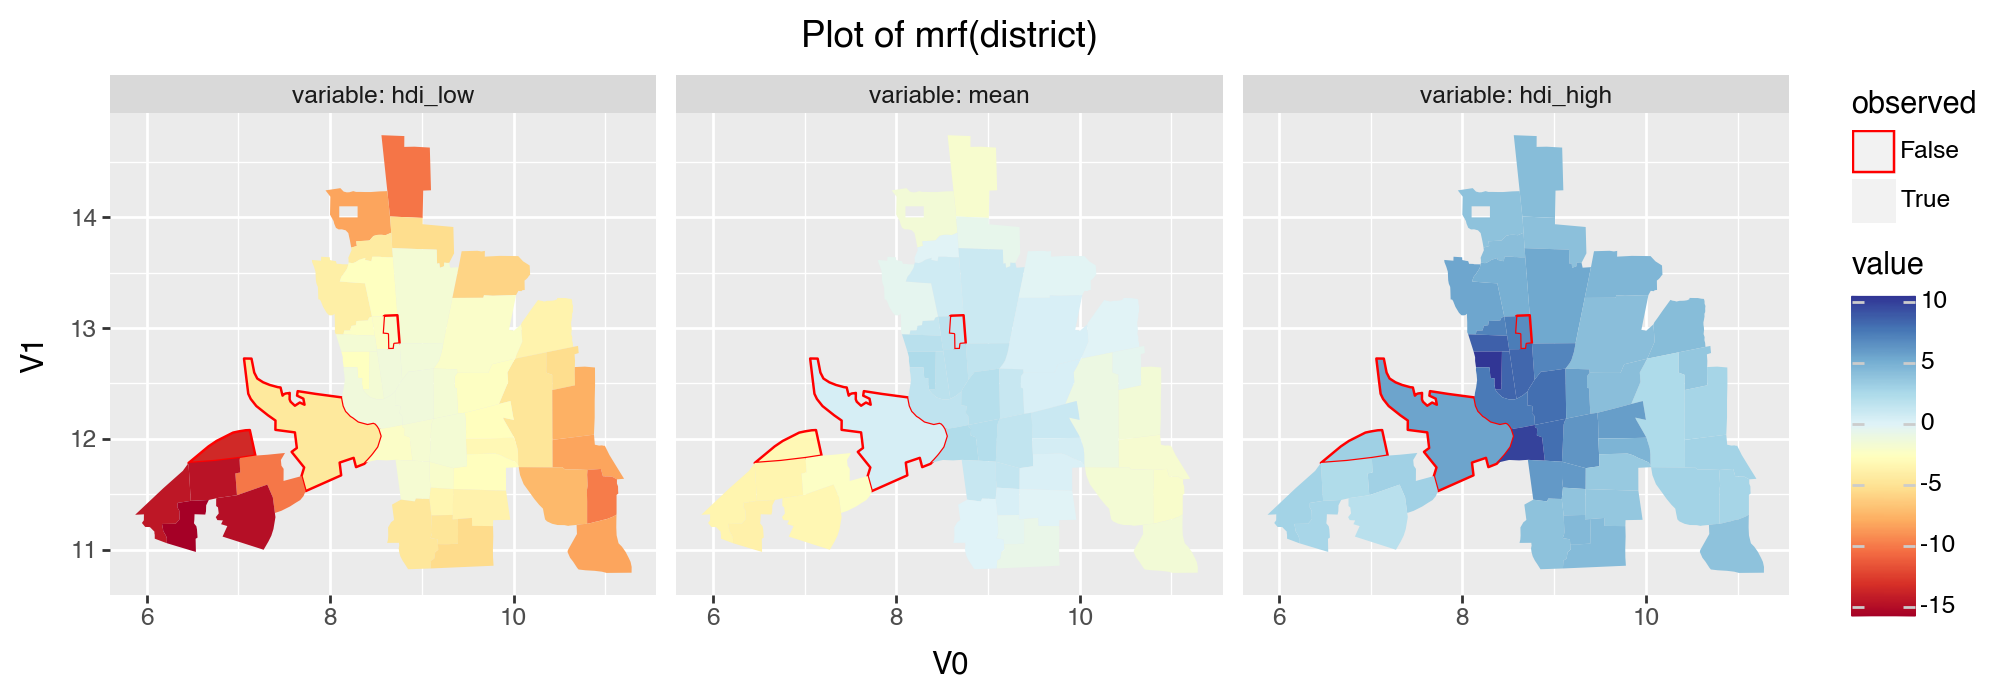

In [13]:
import plotnine as p9

(
    gam.plot_regions(
        term=loc.terms["mrf(district)"],
        samples=samples,
        polys=polys,
        which=["hdi_low", "mean", "hdi_high"],
        observed_color="none",
        unobserved_color="red",
        # show_unobserved=False
    )
    + p9.theme(figure_size=(10, 3.5))
    + p9.scale_fill_cmap("RdYlBu")
)

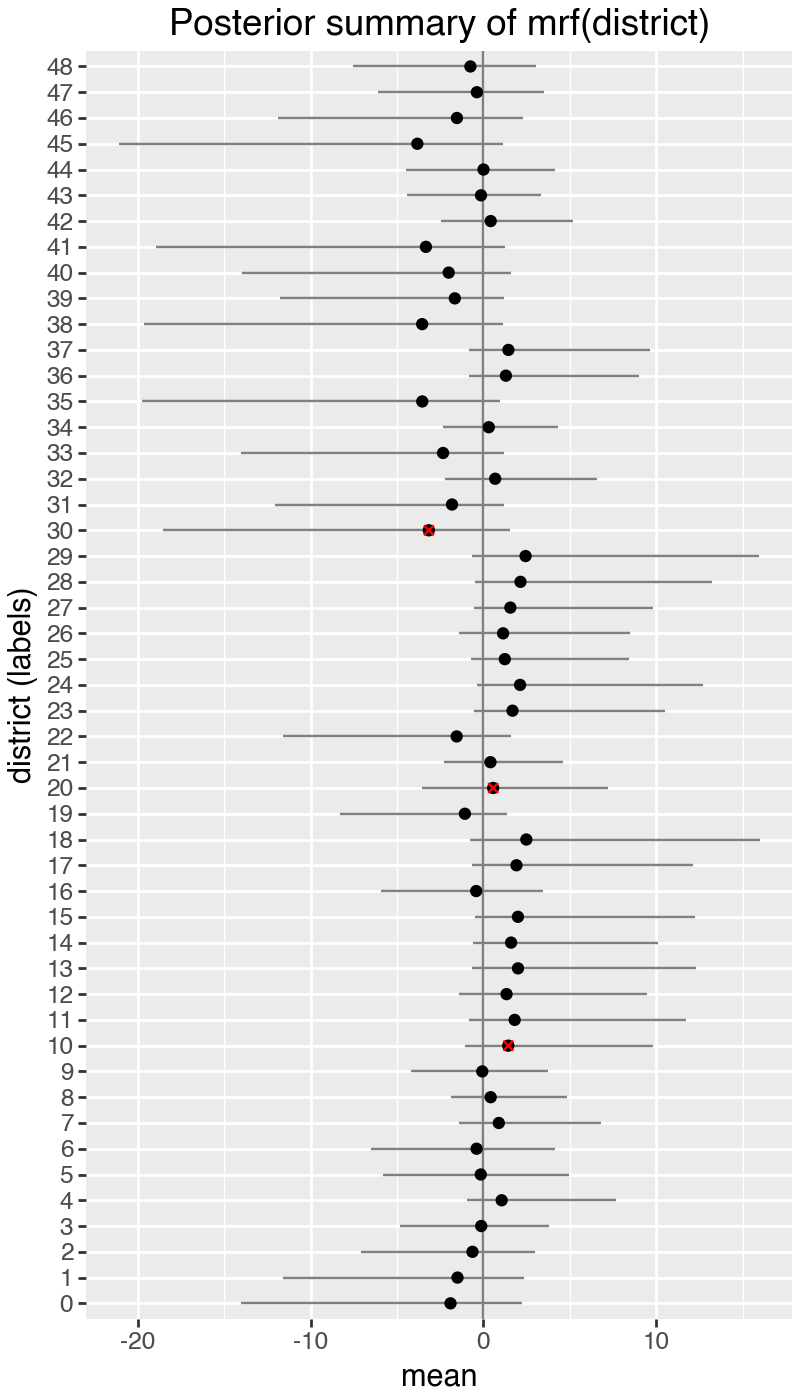

In [14]:
gam.plot_forest(
    term=loc.terms["mrf(district)"],
    samples=samples,
    ymin="q_0.05",
    ymax="q_0.95",
    show_unobserved=True,
) + p9.theme(figure_size=(4, 7))